# Make analysis of rasters/gpfa and spectrograms/pca

For every run in the session:
 - Load the h5 file generated with the 
 - Get the sync events for the nidq, ap, lf sync channels -> to npy for further synching 
 - Sort spikes
 - Get the bouts/mots and align them to the ap_0 time scale
 - make and view some 'bout rasters'
 

Assumes that preprocessing has occured:
- sglx_preprocess:
    - extraction of microphone streams
    - bout detections
- curate_bouts-bird-plotly-ephys:
    - manual curation of detected bouts
- sort_raster_bout:
    - syncrhonization of nidaq/ap time events
    - spike sorting
    - labeling of sorted units for their corresponding nucleus
    - inspection of rasters
    
- load_raster_bout_gpfa
    - for all curated bouts:
        - get the rasters
        - get the spectrograms
    - get the gpfa projections
    - get the pca projections
    - save everything into a h5f file
    
This notebook should not depend on anything other than the h5 file

In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import socket
import tempfile
import multiprocessing
import json
import h5py

import numpy as np
import pandas as pd

from scipy.io import wavfile
from scipy import signal, stats
from matplotlib import pyplot as plt

from importlib import reload
from multiprocessing import Process
from sklearn import linear_model


logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

N_JOBS_MAX = multiprocessing.cpu_count()

logger.info('Running on {}'.format(socket.gethostname()))

2023-02-24 01:42:35,304 root         INFO     Running on pakhi.ucsd.edu


In [2]:
from ceciestunepipe.file import bcistructure as et

from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import sglxsync as sy
from ceciestunepipe.util import stimutil as su
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.util import wavutil as wu
from ceciestunepipe.util import fileutil as fu
from ceciestunepipe.util import h5util as h5u
from ceciestunepipe.util import jitarray as ja
#from ceciestunepipe.util.spike import kilosort as ks
from ceciestunepipe.util.sound import spectral as sp

from ceciestunepipe.pipeline import searchbout as sb

logger.info('all modules loaded')

2023-02-24 01:42:56,280 root         INFO     all modules loaded


### Session parameters

In [3]:
reload(et)

bird = 's_b1555_22'
all_bird_sess = et.list_sessions(bird)
#all_bird_sess

In [7]:
reload(et)

sess_par = {'bird': bird,
           'sess': '2022-07-16',
           'probe': 'probe_0',
           'sort': 'sort_1',
           'trial_tag_chan': 0, # what whas the tag channel in the stimulus wave (this should come from meta et. al)
            'on_signal': 1, # whether singnal on is hi or lo
            'ref_stream': 'ap_0', #what to syncrhonize everything to
           'stim_sess': None, # if there was a stimulus epoch, where the stimuli were coming from
           'mic_chan': 0, # where the microphone is in the wav_mic.npy array
           'pre_chan': 0} # where the pressure is in the wav_adc.npy array




In [8]:
exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])
sess_epochs = et.list_sgl_epochs(sess_par)
sess_epochs

2023-02-24 01:43:09,104 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1555_22', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16/sglx', 'kwik': '/scratch/earneodo/s_b1555_22/sglx/kwik/2022-07-16', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-07-16/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-07-16/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/s_b1555_22/sglx/msort/2022-07-16', 'ksort': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-07-16/sort_1', 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-07-16/sglx/sort_1'}, 'files': {'par': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-07-16/sort_1/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16/sglx/rig.json', 'kwd': '/scratch/

['0703_g0', '1426_g0']

In [9]:
### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[1] # g2 is the shortest
sess_par['epoch'] = epoch

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

derived_folder = exp_struct['folders']['derived']

In [10]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/1426_g0',
  'raw': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16/1426_g0',
  'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16/sglx/1426_g0',
  'kwik': '/scratch/earneodo/s_b1555_22/sglx/kwik/2022-07-16/1426_g0',
  'processed': '/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-07-16/sglx/1426_g0',
  'derived': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-07-16/sglx/1426_g0',
  'tmp': '/scratch/earneodo/tmp/1426_g0',
  'msort': '/scratch/earneodo/s_b1555_22/sglx/msort/2022-07-16/1426_g0',
  'ksort': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-07-16/1426_g0/sort_1',
  'sort': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-07-16/sglx/1426_g0/sort_1'},
 'files': {'par': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-07-16/1426_g0/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16/sglx/settings.isf',
  'rig': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-0

In [11]:
bout_h5_path = os.path.join(exp_struct['folders']['processed'], 'bout_df_gpfa.h5')
bout_h5_path

'/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-07-16/sglx/1426_g0/bout_df_gpfa.h5'

### load epoch h5 file

load the elements of an bout_df_gpfa.h5 file
in the h5 file

In [17]:
bout_h5_path = os.path.join(exp_struct['folders']['processed'], 'bout_df_gpfa-15.h5')
#bout_df, bout_dict = h5u.bouts_from_h5(bout_h5_path, exclude_dset=['spk_arr'])
# load with everything and spikes to get the pca of the neural traces
bout_df, bout_dict = h5u.bouts_from_h5(bout_h5_path, exclude_dset=[])
bout_df.sort_values(['len_ms'], ascending=False, inplace=True, ignore_index=False)

2023-02-24 01:48:03,217 ceciestunepipe.util.h5util INFO     Loading bouts with their gpfa fits from /mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-07-16/sglx/1426_g0/bout_df_gpfa-15.h5


In [15]:
proc_folder = exp_struct['folders']['processed']

In [16]:
!ls $proc_folder

bout_df_gpfa-15.h5  pre_fig.eps  pre_fit_fig.eps  ra_gpfa.eps
bout_df_gpfa.h5     pre_fig.png  pre_fit_fig.png  ra_gpfa.png


In [13]:
bout_dict

{'s_f': 40000,
 's_f_ap_0': 30000.11083350215,
 's_f_nidq': 39999.41886690526,
 't_post': 5,
 't_pre': -5}

In [18]:
### this will come in the bout_dict, with the parameters used to make the fit that comes in bout_d['spk_gpf']
if not 'gpfa_bin_ms' in bout_dict.keys():
    bout_dict['gpfa_bin_ms'] = 15
    
if not 'gpfa_xdim' in bout_dict.keys():
    bout_dict['gpfa_xdim'] = 8

In [19]:
bout_df['spk_arr'].fillna(0, inplace=True)

In [20]:
bout_df.keys()

Index(['index', 'f_xx', 'mic_arr', 'pre_arr', 'pre_filt', 's_xx', 'spk_arr',
       'spk_gpf', 'sxx_pc', 'syl_in', 't_xx', 'bout_check', 'confusing',
       'end_ms', 'end_sample', 'end_sample_ap_0', 'file', 'len_ms',
       'len_sample_ap_0', 'start_ms', 'start_ms_ap_0', 'start_sample',
       'start_sample_ap_0', 'start_sample_naive', 'bout_idx'],
      dtype='object')

In [21]:
bout_df.iloc[0]['spk_arr'].shape

(117, 2191056)

In [22]:
bout_df.keys()

Index(['index', 'f_xx', 'mic_arr', 'pre_arr', 'pre_filt', 's_xx', 'spk_arr',
       'spk_gpf', 'sxx_pc', 'syl_in', 't_xx', 'bout_check', 'confusing',
       'end_ms', 'end_sample', 'end_sample_ap_0', 'file', 'len_ms',
       'len_sample_ap_0', 'start_ms', 'start_ms_ap_0', 'start_sample',
       'start_sample_ap_0', 'start_sample_naive', 'bout_idx'],
      dtype='object')

In [23]:
bout_dict

{'gpfa_bin_ms': 15,
 'gpfa_xdim': 8,
 's_f': 40000,
 's_f_ap_0': 30000.11083350215,
 's_f_nidq': 39999.41886690526,
 't_post': 5,
 't_pre': -5}

In [24]:
bout_s = bout_df.iloc[1]

In [25]:
spk_arr = bout_s['spk_arr']

spk_arr.shape

(117, 2118456)

In [26]:
np.where(spk_arr>0)

(array([  0,   0,   0, ..., 115, 116, 116]),
 array([    311,    1569,    2748, ..., 2108160,  154387,  588311]))

### Further views of data:
- Spike rasters in miliseconds, bins equivalent to the gpfa bin size
- Envelope and log of envelope, in same bin size as the gpfa

In [27]:
bin_ms = 15 # for all comparisons, bin size should be the same across all observables (determined by the gpfa; this should be stored in the h5 file)
ms_sample_ap = int(1*0.001*bout_dict['s_f_ap_0'])
ms_sample_wav = int(1*0.001*bout_dict['s_f'])
bin_sample_ap = int(bin_ms*0.001*bout_dict['s_f_ap_0'])
bin_sample_wav = int(bin_ms*0.001*bout_dict['s_f'])

In [28]:
bout_dict

{'gpfa_bin_ms': 15,
 'gpfa_xdim': 8,
 's_f': 40000,
 's_f_ap_0': 30000.11083350215,
 's_f_nidq': 39999.41886690526,
 't_post': 5,
 't_pre': -5}

##### histogram

In [29]:
bout_df['spk_bin_arr'] = bout_df['spk_arr'].apply(lambda z: np.nan_to_num(pu.coarse(z, bin_sample_ap)))
bout_df['spk_ms_arr'] = bout_df['spk_arr'].apply(lambda z: np.nan_to_num(pu.coarse(z, ms_sample_ap)))

##### envelope

In [30]:
bout_df['s_xx_env'] = bout_df['s_xx'].apply(lambda z: np.nansum(z, axis=0))
bout_df['env_bin'] = bout_df['s_xx_env'].apply(lambda z: np.nan_to_num(pu.coarse(z, bin_ms)))
bout_df['env_log'] = bout_df['env_bin'].apply(lambda z: np.log(z))
bout_df['pre_ms'] = bout_df['pre_filt'].apply(lambda z: np.nan_to_num(pu.coarse(z, ms_sample_wav)))
bout_df['pre_bin'] = bout_df['pre_filt'].apply(lambda z: np.nan_to_num(pu.coarse(z, bin_sample_wav)))
#bout_df['env_bin'] = bout_df['mic_arr'].apply(lambda z: np.nan_to_num(pu.coarse(z, bin_sample_wav)))

#bout_df['sxx_env'] = bout_df['s_xx'].apply(lambda z: np.nan_to_num(pu.coarse(np.nansum(z, axis=0), bin_sample_wav)))
#bout_df['sxx_env'] = bout_df['sxx_bin'].apply(lambda z: np.nansum(z, axis=0))

In [31]:
bout_series = bout_df.iloc[0]
bout_series['pre_bin'].shape

(4869,)

In [32]:
bout_series['spk_arr'].shape[1]/bout_dict['s_f_ap_0']/15

4.868995345073132

In [33]:
bout_series['pre_arr'].shape[0]/bout_dict['s_f']/15

4.869

In [34]:
bout_series['spk_bin_arr'].shape

(117, 4869)

In [35]:
bout_df.keys()

Index(['index', 'f_xx', 'mic_arr', 'pre_arr', 'pre_filt', 's_xx', 'spk_arr',
       'spk_gpf', 'sxx_pc', 'syl_in', 't_xx', 'bout_check', 'confusing',
       'end_ms', 'end_sample', 'end_sample_ap_0', 'file', 'len_ms',
       'len_sample_ap_0', 'start_ms', 'start_ms_ap_0', 'start_sample',
       'start_sample_ap_0', 'start_sample_naive', 'bout_idx', 'spk_bin_arr',
       'spk_ms_arr', 's_xx_env', 'env_bin', 'env_log', 'pre_ms', 'pre_bin'],
      dtype='object')

In [36]:
### trim a part of the bout to do an analysis

In [37]:
def bout_trim(bpd: pd.DataFrame, bout_dict: dict, trim: str='bout') -> pd.DataFrame:
    # trim all the time series to either of 'bout', 'pre', 'post'
    bin_ms = 15 # for all comparisons, bin size should be the same across all observables (determined by the gpfa; this should be stored in the h5 file)
    ms_sample_ap = int(1*0.001*bout_dict['s_f_ap_0'])
    ms_sample_wav = int(1*0.001*bout_dict['s_f'])
    bin_sample_ap = int(bin_ms*0.001*bout_dict['s_f_ap_0'])
    bin_sample_wav = int(bin_ms*0.001*bout_dict['s_f'])
    
    

### get the pca of the neural activity
- get all the binned spikes for each bout
- get the pc transformation using all bouts
- apply the transform to all bouts

In [38]:
all_spk_arr = np.hstack(bout_df['spk_bin_arr'])

In [39]:
np.sum(all_spk_arr>0)

1917366

In [40]:
from sklearn.decomposition import PCA

all_spk_arr = np.hstack(bout_df['spk_bin_arr']) # [n_unit, n_bin for all bouts]

# make the pca transform
pca = PCA(n_components=8)
pca.fit(all_spk_arr.T)
#apply the transform to all series in the dataframe

PCA(n_components=8)

In [41]:
bout_df['spk_pc'] = bout_df['spk_bin_arr'].apply(lambda x: pca.transform(x.T))

In [42]:
print(pca.explained_variance_ratio_)

[0.0648446  0.03960642 0.03215103 0.02809938 0.0277509  0.02658566
 0.02354175 0.02222895]


### Visualize a bout together with the neural traces

In [43]:
plt.rcParams['lines.linewidth'] = 0.1

In [44]:
axes_pars = {'axes.labelpad': 5,
             'axes.titlepad': 5,
             'axes.titlesize': 'small',
             'axes.grid': False,
             'axes.xmargin': 0,
             'axes.ymargin': 0}

plt.rcParams.update(axes_pars)

##### sanity check, plot one of the bout-rasters

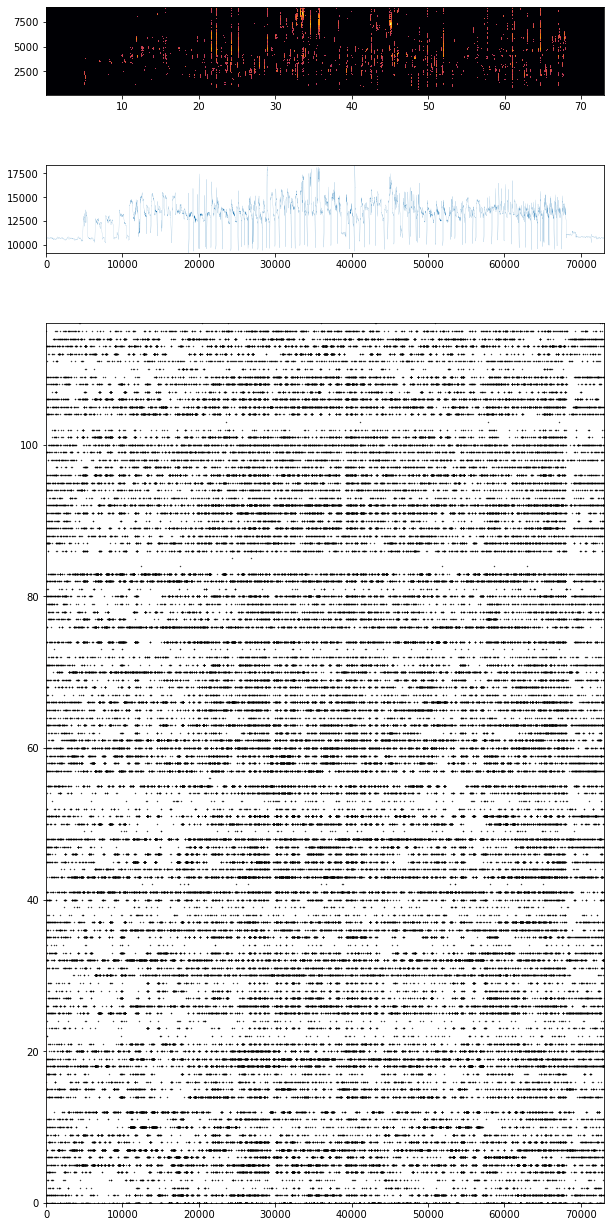

In [45]:
def plot_bout(bout_series, bout_dict, plot_raster=False):
    # get the raster, the spectrogram and the pressure
    
    t_pre = bout_dict['t_pre']
    s_f_ap = bout_dict['s_f_ap_0']
    s_f = bout_dict['s_f']
    
    mic_arr = bout_series['mic_arr']
    pre_arr = bout_series['pre_ms']
    
    # plot
    
    fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

    f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f)

    #ax[0].plot(mic_arr.flatten())
    ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    ax[1].plot(pre_arr.flatten());
    
    if plot_raster:
        spk_arr = bout_series['spk_ms_arr']
        pu.plot_as_raster(spk_arr, t_0=int(-t_pre*0.01), ax=ax[2])
    
plot_bout(bout_df.iloc[0], bout_dict, plot_raster=True)

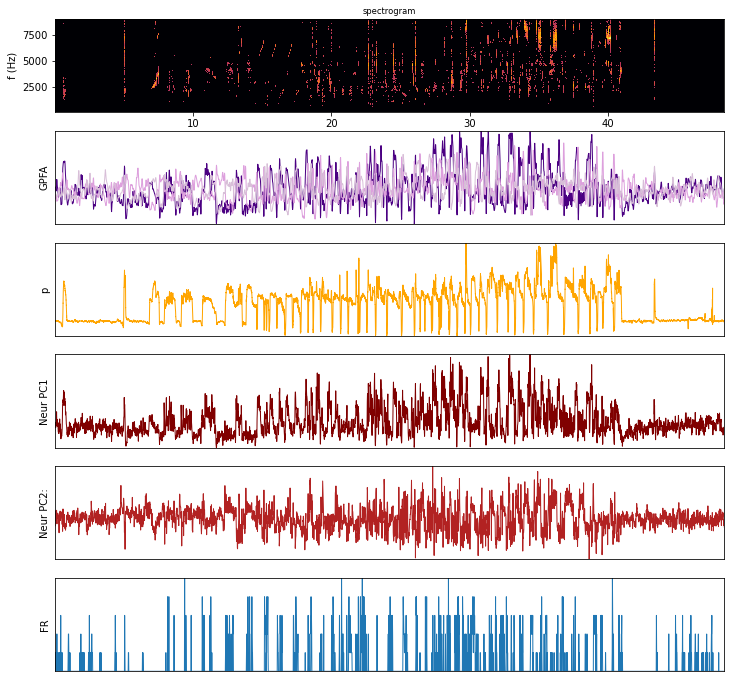

In [61]:
### se them together all for a bout now
def plot_bout_projections(bout_series):
    sxx_pc = bout_series['sxx_pc']
    spk_pc = bout_series['spk_pc']
    spk_arr = bout_series['spk_arr']
    spk_bin = bout_series['spk_bin_arr']
    gpf = bout_series['spk_gpf']
    pre_arr = bout_series['pre_filt']
    mic_arr = bout_series['mic_arr']
    
    f, t, sxx = tuple([bout_series['f_xx'], bout_series['t_xx'], bout_series['s_xx']])
    
    fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(12, 12));

    ax[0].set_title('spectrogram')
    ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    ax[0].set_xlabel('t (sec.)')
    ax[0].set_ylabel('f (Hz)')
    
    #ax[1].plot((np.abs(mic_arr)), 'k');
    #ax[1].set_ylabel('sound amplitude (arb)')

    #ax[2].set_title('spectrogram PC')
    #ax[2].plot(sxx_pc[:, 0], 'k', lw=1);

    #ax[1].set_title('RA GPFA');
    ax[1].set_prop_cycle(color=['indigo', 'plum', 'thistle'])
    #ax[1].set_prop_cycle(color=plt.cycler("color", list(plt.cycler("color", plt.cm.Set2.colors))))
    ax[1].plot(gpf[:3].T, lw=1);
    ax[1].set_ylabel('GPFA')

    #ax[2].set_title('pressure');
    ax[2].plot(pre_arr, 'orange', lw=1);
    ax[2].set_ylabel('p')
    
    #ax[1].set_title('PC');
    ax[3].set_prop_cycle(color=['maroon', 'firebrick', 'lightcoral'])
    #ax[1].set_prop_cycle(color=plt.cycler("color", list(plt.cycler("color", plt.cm.Set2.colors))))
    pc_plot = ja.substract_mean_col(spk_pc.T).T
    ax[3].plot(pc_plot.T[:1].T, lw=1);
    ax[3].set_ylabel('Neur PC1')
    #bin_spk_arr = pu.coarse(spk_arr, 30*15)
    #ax[3].plot(bin_spk_arr.sum(axis=0))
    
    ax[4].set_prop_cycle(color=['firebrick', 'lightcoral', 'maroon'])
    ax[4].plot(pc_plot.T[4:5].T, lw=1);
    ax[4].set_ylabel('Neur PC2:')
    
    ax[5].set_ylabel('FR')
    #ax[5].plot(spk_bin.sum(axis=0), lw=1)
    ax[5].plot(spk_bin[55], lw=1)
    
    for ax_i in ax[1:]:
        ax_i.set_xticks([])
        ax_i.set_yticks([])
    
    return fig


gpfa_pre_fig = plot_bout_projections(bout_df.iloc[20])

In [19]:
##save the figure
fig_path = os.path.join(exp_struct['folders']['processed'], 'pre_fig')
#gpfa_pre_fig.savefig(fig_path + '.png')
#gpfa_pre_fig.savefig(fig_path + '.eps')
logger.info('saved figure in ' + fig_path)

2022-09-22 08:25:12,168 root         INFO     saved figure in /mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-04-29/sglx/0644_g0/pre_fig


### Try a linear fit from the fr to the pressure, and see the loading matrix of that regression

- check bin sizes
- make a fit
- assess goodness of fit
- rank the weights

In [47]:
bout_ds = bout_df.iloc[20]

spk_pc = bout_ds['spk_pc']
spk_arr = bout_ds['spk_arr']
spk_bin = bout_ds['spk_bin_arr']
gpf = bout_ds['spk_gpf']
pre_bin = bout_ds['pre_bin']
mic_arr = bout_ds['mic_arr']

In [48]:
spk_bin.shape

(117, 3227)

In [49]:
pre_bin.shape

(3227,)

###### one fit

In [50]:
all_spk = np.vstack([x.T[:-1] for x in bout_df['spk_bin_arr']])

In [51]:
all_pre = np.hstack([x.T[1:] for x in bout_df['pre_bin']])

In [52]:
reg = linear_model.LinearRegression()
reg.fit(all_spk, all_pre)

LinearRegression()

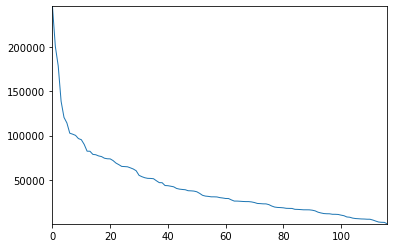

In [53]:
unit_coef_sort = np.argsort(np.abs(reg.coef_))[::-1]
plt.plot((np.abs(reg.coef_[unit_coef_sort])), lw=1)

In [54]:
unit_coef_sort

array([ 84,  30,  19,  12, 116, 107, 112,  64,  20,  99,  44,  10,  58,
        47,   2,  86,  80,  55,   3,  56,  36,  43,  34,  82, 110,  27,
        66,   9,  29, 106,  91,  53,  33,  97,  69,  61,  76,  31,  79,
       105,  87,  92,  65,  57,  74,   4,  21,  94,  60, 113,  15,   1,
        77, 115,  32,  93,  88, 111,  50, 102,   5,  95,  59,  68,  71,
       109, 114,  22,  89,  25,  23,  51,  45,  81, 108,  98,  38,  42,
        78,  16,   0,  96,  14, 104,  49,  40,  26,   7,  28,  63,  13,
        67,  37,  54,  83,  75,  39,  24, 100,  85,   6,   8,  73,  35,
       101, 103,  11,  46,  17,  62,  48,  72,  18,  90,  70,  41,  52])

In [55]:
np.sum(bout_df.iloc[0]['spk_bin_arr'][51])

4.8

In [56]:
n_unit = 40
pick_units = unit_coef_sort[:n_unit]

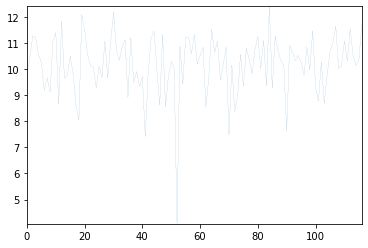

In [57]:
plt.plot(np.log(np.abs(reg.coef_)))

In [58]:
bout_df['pre_fr_fit'] = bout_df['spk_bin_arr'].apply(lambda x: reg.predict(x.T))

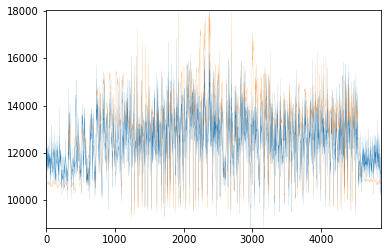

In [59]:
plt.plot(bout_df.iloc[0]['pre_fr_fit'])
plt.plot(bout_df.iloc[0]['pre_bin'])

### make a second gpfa with the subset that best does the linear fit

In [66]:
from ceciestunepipe.util.dimension import gpfa
import neo
import quantities as pq
from elephant.gpfa import GPFA
import viziphant as vp

In [69]:
# # specify fitting parameters
# bin_size = 15 * pq.ms
# x_dim = 8

In [70]:
# top_unit_idx = unit_coef_sort[:40]
# bout_df['spk_train_t40'] = bout_df['spk_arr'].apply(lambda x: gpfa.spike_trains_from_spk_arr(x, bout_dict['s_f_ap_0'], 
#                                                                                              unit_idx_arr = top_unit_idx))

# gpfa_model = GPFA(bin_size=bin_size, x_dim=x_dim)

# #fit
# gpfa_model.fit(top_spk_train_list)

# #project
# bout_df['spk_gpf_t40'] = gpfa_model.transform(list(bout_df['spk_train_t40']))

/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 6 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 5 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-

Initializing parameters using factor analysis...

Fitting GPFA model...


/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 6 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 5 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-

In [74]:
# bottom_unit_idx = unit_coef_sort[-40:]
# bout_df['spk_train_b40'] = bout_df['spk_arr'].apply(lambda x: gpfa.spike_trains_from_spk_arr(x, bout_dict['s_f_ap_0'], 
#                                                                                              unit_idx_arr = bottom_unit_idx))
# bottom_spk_train_list = list(bout_df['spk_train_b40'])

# gpfa_model_b = GPFA(bin_size=bin_size, x_dim=x_dim)

# #fit
# gpfa_model_b.fit(bottom_spk_train_list)

# #project
# bout_df['spk_gpf_b40'] = gpfa_model.transform(bottom_spk_train_list)

/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 7 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 11 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 5 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site

Initializing parameters using factor analysis...

Fitting GPFA model...


/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 7 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 11 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 5 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site

In [81]:
bout_df.keys()

Index(['f_xx', 'mic_arr', 'pre_arr', 'pre_filt', 's_xx', 'spk_arr', 'spk_gpf',
       'sxx_pc', 'syl_in', 't_xx', 'bout_check', 'confusing', 'end_ms',
       'end_sample', 'end_sample_ap_0', 'file', 'len_ms', 'len_sample_ap_0',
       'start_ms', 'start_ms_ap_0', 'start_sample', 'start_sample_ap_0',
       'start_sample_naive', 'bout_idx', 'spk_bin_arr', 'spk_ms_arr',
       's_xx_env', 'env_bin', 'env_log', 'pre_ms', 'pre_bin', 'spk_pc',
       'pre_fr_fit', 'spk_train_t40', 'spk_gpf_t40', 'spk_train_b40',
       'spk_gpf_b40'],
      dtype='object')

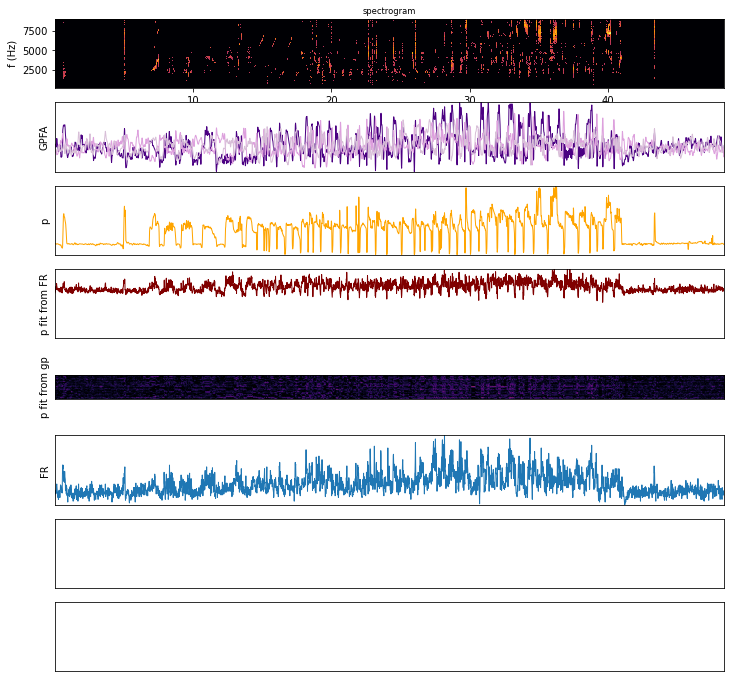

In [63]:
### se them together all for a bout now
def plot_bout_linear_fit(bout_series):
    sxx_pc = bout_series['sxx_pc']
    spk_pc = bout_series['spk_pc']
    spk_arr = bout_series['spk_arr']
    spk_bin = bout_series['spk_bin_arr']
    gpf = bout_series['spk_gpf']
    pre_arr = bout_series['pre_bin']
    pre_fr_fit = bout_series['pre_fr_fit']
    #pre_gp_fit = bout_series['gpf_pre_fit']
    mic_arr = bout_series['mic_arr']
    
    f, t, sxx = tuple([bout_series['f_xx'], bout_series['t_xx'], bout_series['s_xx']])
    
    fig, ax = plt.subplots(nrows=8, ncols=1, figsize=(12, 12));

    ax[0].set_title('spectrogram')
    ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    ax[0].set_xlabel('t (sec.)')
    ax[0].set_ylabel('f (Hz)')
    
    #ax[1].plot((np.abs(mic_arr)), 'k');
    #ax[1].set_ylabel('sound amplitude (arb)')

    #ax[2].set_title('spectrogram PC')
    #ax[2].plot(sxx_pc[:, 0], 'k', lw=1);

    #ax[1].set_title('RA GPFA');
    ax[1].set_prop_cycle(color=['indigo', 'plum', 'thistle'])
    #ax[1].set_prop_cycle(color=plt.cycler("color", list(plt.cycler("color", plt.cm.Set2.colors))))
    ax[1].plot(gpf[:3].T, lw=1);
    ax[1].set_ylabel('GPFA')

    #ax[2].set_title('pressure');
    ax[2].plot(pre_arr, 'orange', lw=1);
    ax[2].set_ylabel('p')
    
    #ax[1].set_title('PC');
    ax[3].set_prop_cycle(color=['maroon', 'firebrick', 'lightcoral'])
    #ax[1].set_prop_cycle(color=plt.cycler("color", list(plt.cycler("color", plt.cm.Set2.colors))))
    pc_plot = ja.substract_mean_col(spk_pc.T).T
    ax[3].plot(pre_fr_fit, lw=1);
    ax[3].set_ylabel('p fit from FR')
    bin_spk_arr = pu.coarse(spk_arr, 30*15)
    ax[3].plot(bin_spk_arr.sum(axis=0))
    
    ax[4].set_prop_cycle(color=['green', 'lightcoral', 'maroon'])
    #ax[4].plot(pre_gp_fit, lw=1);
    ax[4].imshow(np.sqrt(spk_bin[::-1]), cmap='inferno')
    ax[4].set_ylabel('p fit from gp')
    
    ax[5].set_ylabel('FR')
    ax[5].plot(spk_bin.sum(axis=0), lw=1)
    
    #ax[6].set_prop_cycle(color=['indigo', 'plum', 'thistle'])
    #ax[1].set_prop_cycle(color=plt.cycler("color", list(plt.cycler("color", plt.cm.Set2.colors))))
    #ax[6].plot(bout_series['spk_gpf_t40'][:3].T, lw=1);
    #ax[6].set_ylabel('GPFA_t40')
    
    #ax[7].set_prop_cycle(color=['indigo', 'plum', 'thistle'])
    #ax[1].set_prop_cycle(color=plt.cycler("color", list(plt.cycler("color", plt.cm.Set2.colors))))
    #ax[7].plot(bout_series['spk_gpf_b40'][:3].T, lw=1);
    #ax[7].set_ylabel('GPFA_b40')
    
    for ax_i in ax[1:]:
        ax_i.set_xticks([])
        ax_i.set_yticks([])
    return fig


gpfa_pre_fig = plot_bout_linear_fit(bout_df.iloc[20])

### get some distance ideas of the GPF
- one very basic measure: the angular distance to the (1, 1, 1) (the generalized 45 degree)
- in an orthornormal basis, if all the components have the same value, the vector points there.
- if their values differ, the angle diverges from there. 

In [64]:
from scipy.spatial import distance
from itertools import combinations

def angular_spread(x):
    # the angular span relative to the generalized 45 degree direction
    ref = np.ones_like(x)
    return distance.cosine(x, ref)

def component_spread(x):
    all_pairs = np.array(list(combinations(x, 2)))
    #print(all_pairs)
    all_segments = np.diff(all_pairs, axis=1)
    return np.linalg.norm(all_segments)

def component_variance(x):
    return np.va

# apply to all of the bouts
bout_df['gpf_spread'] = bout_df['spk_gpf'].apply(lambda z: np.std(z[:3], axis=0))

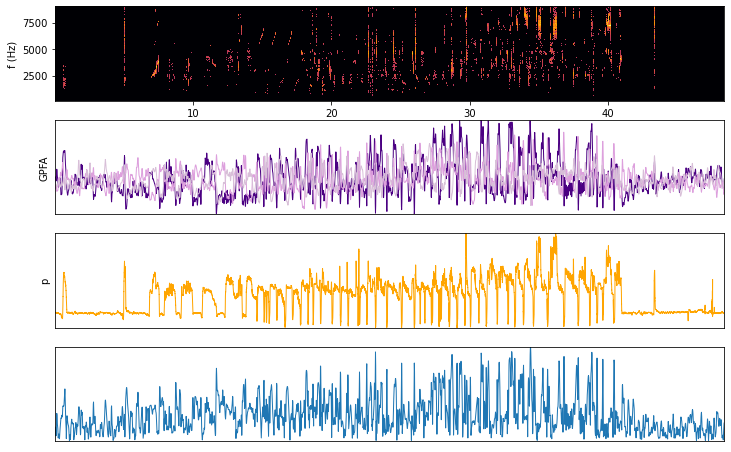

In [66]:
### se them together all for a bout now
def plot_bout_projections_and_dist(bout_series):
    sxx_pc = bout_series['sxx_pc']
    gpf = bout_series['spk_gpf']
    pre_arr = bout_series['pre_filt']
    mic_arr = bout_series['mic_arr']
    
    f, t, sxx = tuple([bout_series['f_xx'], bout_series['t_xx'], bout_series['s_xx']])
    
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12, 8));

    ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    ax[0].set_xlabel('t (sec.)')
    ax[0].set_ylabel('f (Hz)')
    
    #ax[1].plot((np.abs(mic_arr)), 'k');
    #ax[1].set_ylabel('sound amplitude (arb)')

    #ax[2].set_title('spectrogram PC')
    #ax[2].plot(sxx_pc[:, 0], 'k', lw=1);

    #ax[1].set_title('RA GPFA');
    ax[1].set_prop_cycle(color=['indigo', 'plum', 'thistle'])
    #ax[1].set_prop_cycle(color=plt.cycler("color", list(plt.cycler("color", plt.cm.Set2.colors))))
    ax[1].plot(gpf[:3].T, lw=1);
    ax[1].set_ylabel('GPFA')

    #ax[2].set_title('pressure');
    ax[2].plot(pre_arr, 'orange', lw=1);
    ax[2].set_ylabel('p')
    
    ax[3].plot(bout_series['gpf_spread'], lw=1)
    
    for ax_i in ax[1:]:
        ax_i.set_xticks([])
        ax_i.set_yticks([])
    
    return fig


gpfa_pre_fig = plot_bout_projections_and_dist(bout_df.iloc[20])

### try some fit
    - do a linear fit of the pressure from the gpfa (for each bout)
    - get the residual
    - plot together

#### make a pre vector for each bout resampled to match the length of the spk_gpf

In [67]:
bout_df['pre_resample'] = bout_df.apply(lambda s: signal.resample(s['pre_filt'], s['spk_gpf'].shape[-1]), axis=1)

In [68]:
lr = linear_model.LinearRegression()

def fit_pre(s: pd.Series, model, gpf_key: str='spk_gpf', return_score=False):
    x = s[gpf_key][:].T
    y = s['pre_resample'].reshape(-1, 1)
    #logger.info(x.shape)
    #logger.info(y.shape)
    model.fit(x, y)
    if return_score==False:
        return model.predict(x).flatten()
    else:
        return model.predict(x).flatten(), model.score(x, y)
    
def fit_residual(s: pd.Series, model, gpf_key: str='spk_gpf', return_score=False):
    x = s[gpf_key][2:6].T
    y = s['gpf_pre_fit_err'].reshape(-1, 1)
    #logger.info(x.shape)
    #logger.info(y.shape)
    model.fit(x, y)
    if return_score==False:
        return model.predict(x).flatten()
    else:
        return model.predict(x).flatten(), model.score(x, y)

one_fit = fit_pre(bout_df.iloc[0], lr)

bout_df['gpf_pre_fit'] = bout_df.apply(lambda s: fit_pre(s, lr), axis=1)
bout_df['gpf_pre_fit_err'] = bout_df.apply(lambda s: np.abs(s['pre_resample'] - s['gpf_pre_fit'])/s['pre_resample'], 
                                           axis=1)

bout_df['gpf_res_fit'] = bout_df.apply(lambda s: fit_residual(s, lr), axis=1)

In [69]:
# for unit_part_key in ['_t40', '_b40']:
#     gpf_key = 'spk_gpf{}'.format(unit_part_key)
#     fit_key = 'gpf_pre_fit{}'.format(unit_part_key)
    
#     bout_df[fit_key] = bout_df.apply(lambda s: fit_pre(s, lr, gpf_key=gpf_key), axis=1)

KeyError: 'spk_gpf_t40'

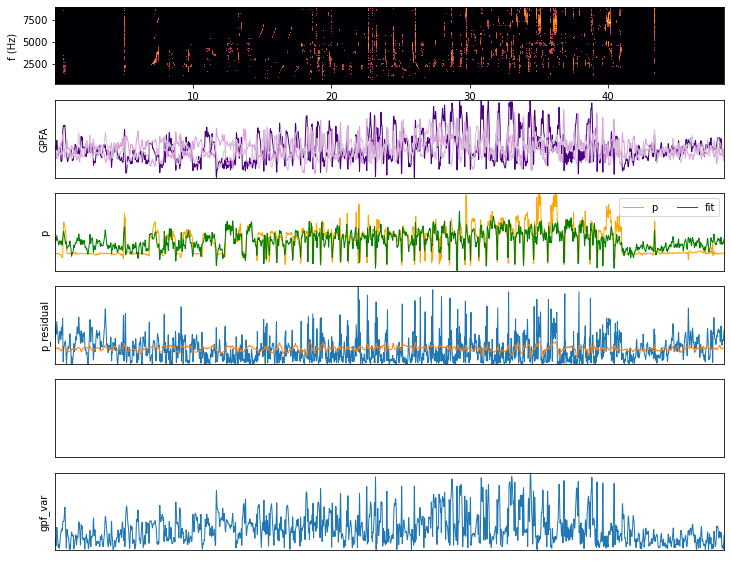

In [71]:
### se them together all for a bout now
def plot_bout_projections_and_fit(bout_series):
    sxx_pc = bout_series['sxx_pc']
    gpf = bout_series['spk_gpf']
    pre_arr = bout_series['pre_resample']
    mic_arr = bout_series['mic_arr']
    
    f, t, sxx = tuple([bout_series['f_xx'], bout_series['t_xx'], bout_series['s_xx']])
    
    fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(12, 10));

    ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    ax[0].set_xlabel('t (sec.)')
    ax[0].set_ylabel('f (Hz)')
    
    #ax[1].plot((np.abs(mic_arr)), 'k');
    #ax[1].set_ylabel('sound amplitude (arb)')

    #ax[2].set_title('spectrogram PC')
    #ax[2].plot(sxx_pc[:, 0], 'k', lw=1);

    #ax[1].set_title('RA GPFA');
    ax[1].set_prop_cycle(color=['indigo', 'plum', 'thistle'])
    #ax[1].set_prop_cycle(color=plt.cycler("color", list(plt.cycler("color", plt.cm.Set2.colors))))
    ax[1].plot(gpf[:3].T, lw=1);
    ax[1].set_ylabel('GPFA')

    #ax[2].set_title('pressure');
    ax[2].plot(pre_arr, 'orange', lw=1, label='p');
    ax[2].set_ylabel('p')
    ax[2].plot(bout_series['gpf_pre_fit'], 'green', lw=1, label='fit')
    #ax[2].plot(bout_series['gpf_pre_fit_t40'], 'red', lw=1, label='fit_t40')
    #ax[2].plot(bout_series['gpf_pre_fit_b40'], 'blue', lw=1, label='fit_b40')
    ax[2].legend(ncol=2)

    ax[3].plot(bout_series['gpf_pre_fit_err'], lw=1)
    ax[3].set_ylabel('p_residual')

    
    ax[3].plot(bout_series['gpf_res_fit'], lw=1)
    #ax[4].set_ylabel('p_residual_fit')
    
    ax[5].plot(bout_series['gpf_spread'], lw=1)
    ax[5].set_ylabel('gpf_var')
    
    for ax_i in ax[1:]:
        ax_i.set_xticks([])
        ax_i.set_yticks([])
    
    return fig


gpfa_pre_fig = plot_bout_projections_and_fit(bout_df.iloc[20])

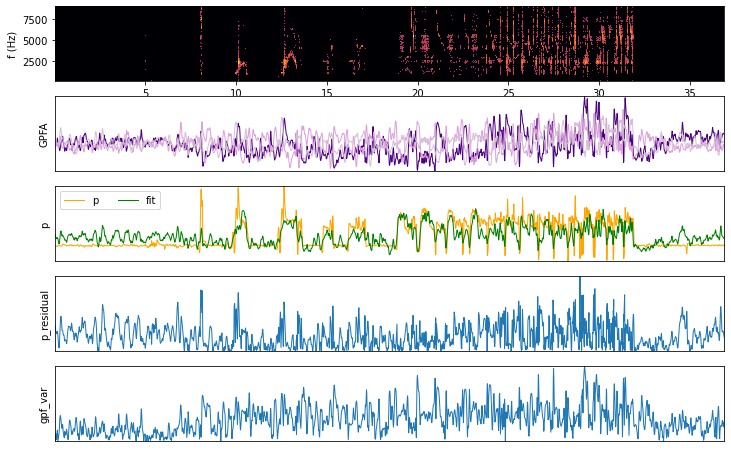

In [76]:
### se them together all for a bout now
def plot_bout_projections_and_fit(bout_series):
    sxx_pc = bout_series['sxx_pc']
    gpf = bout_series['spk_gpf']
    pre_arr = bout_series['pre_resample']
    mic_arr = bout_series['mic_arr']
    
    f, t, sxx = tuple([bout_series['f_xx'], bout_series['t_xx'], bout_series['s_xx']])
    
    fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 8));

    ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    ax[0].set_xlabel('t (sec.)')
    ax[0].set_ylabel('f (Hz)')
    
    #ax[1].plot((np.abs(mic_arr)), 'k');
    #ax[1].set_ylabel('sound amplitude (arb)')

    #ax[2].set_title('spectrogram PC')
    #ax[2].plot(sxx_pc[:, 0], 'k', lw=1);

    #ax[1].set_title('RA GPFA');
    ax[1].set_prop_cycle(color=['indigo', 'plum', 'thistle'])
    #ax[1].set_prop_cycle(color=plt.cycler("color", list(plt.cycler("color", plt.cm.Set2.colors))))
    ax[1].plot(gpf[:3].T, lw=1);
    ax[1].set_ylabel('GPFA')

    #ax[2].set_title('pressure');
    ax[2].plot(pre_arr, 'orange', lw=1, label='p');
    ax[2].set_ylabel('p')
    ax[2].plot(bout_series['gpf_pre_fit'], 'green', lw=1, label='fit')
    ax[2].legend(ncol=2)

    ax[3].plot(bout_series['gpf_pre_fit_err'], lw=1)
    ax[3].set_ylabel('p_residual')

    
    ax[4].plot(bout_series['gpf_spread'], lw=1)
    ax[4].set_ylabel('gpf_var')
    
    for ax_i in ax[1:]:
        ax_i.set_xticks([])
        ax_i.set_yticks([])
    
    return fig


gpfa_pre_fig = plot_bout_projections_and_fit(bout_df.iloc[24])

In [86]:
bout_df.iloc[0]['spk_gpf'].shape

(8, 4868)

#### do crosscorrelation, mutual information analyses

In [87]:
for i in range(3):
    bout_df['spk_gpf_'+ str(i)] = bout_df['spk_gpf'].apply(lambda x: x[i])
    bout_df['spk_gpf_'+ str(2*i+1)] = bout_df['spk_gpf'].apply(lambda x: x[2*i+1])
    bout_df['sxx_pc_'+ str(i)] = bout_df['sxx_pc'].apply(lambda x: x[:, i])

In [102]:
for unit_part_key in ['_t40', '_b40']:
    gpf_key = 'spk_gpf{}'.format(unit_part_key)
    fit_key = 'gpf_pre_fit{}'.format(unit_part_key)
    
    bout_df[fit_key] = bout_df.apply(lambda s: fit_pre(s, lr, gpf_key=gpf_key), axis=1)
    
    for i in range(3):
        bout_df['{}_{}'.format(gpf_key, str(i))] = bout_df[gpf_key].apply(lambda x: x[i])
        bout_df['spk_gpf_'+ str(i)] = bout_df['spk_gpf'].apply(lambda x: x[i])
        bout_df['{}_{}'.format(gpf_key, str(2*i+1))] = bout_df[gpf_key].apply(lambda x: x[2*i+1])

In [88]:
from sklearn.feature_selection import mutual_info_regression
from scipy.signal import correlate2d
from scipy.stats import pearsonr

In [89]:
### make a many_column, continuous dataframe,with the streams of each bout all concatenated

def bout_series_df(bout_s: pd.Series, tag_pair: list=['spk_gpf_0', 'sxx_pc_0']) -> pd.DataFrame:
    # t has to be in last axis
    tag_tuple = tuple(tag_pair)
    
    # subsample everything to the series with the least temporal resolution (gp, 15ms bins)
    n_samp_arr = np.array([bout_s[x].shape[-1] for x in tag_pair])
    #logger.info(n_samp_arr)
    # sort by number of samples (0 is smaller, 1 is larger)
    size_order = np.argsort(n_samp_arr)
    short_tag, long_tag = np.array(tag_pair)[size_order]
    
    # leav the smaller untouched (the 0), subsample the larger (1)
    sizes_ranked = np.sort(n_samp_arr)
    size_ratio = sizes_ranked[1]//sizes_ranked[0]
    
    long_s = pu.coarse(bout_s[long_tag], size_ratio)[:sizes_ranked[0]]
    short_s = bout_s[short_tag]
    
    bout_df = pd.DataFrame({long_tag: long_s, short_tag: short_s})
    #bout_df['bout_idx'] = bout_s['bout_idx']
    return bout_df
    

def bout_df_to_cols(df: pd.DataFrame, tag_pair: list=['spk_gpf_0', 'sxx_pc_0']) -> pd.DataFrame:
    # go over the bout_df and get the two columns in a continous, synced dataframe
    return pd.concat([bout_series_df(x, tag_pair=tag_pair) for i, x in bout_df.iterrows()])

#bout_series_df(bout_df.iloc[0])
#pd.concat([bout_series_df(x) for i, x in bout_df.iterrows()])

bout_df_to_cols(bout_df)

,sxx_pc_0,spk_gpf_0
0,-4.757034,0.478902
1,-4.757034,0.537999
2,-4.757034,0.515812
3,-4.757034,0.363938
4,-4.757034,0.104684
...,...,...
864,-4.757034,-0.214301
865,-4.757034,0.020495
866,-4.757034,0.157859
867,-4.757034,0.127810


In [90]:
pairs_to_df = [['spk_gpf_0', 'sxx_pc_0'], 
               ['spk_gpf_1', 'sxx_pc_1'],
               ['spk_gpf_2', 'sxx_pc_2'],
               ['spk_gpf_3', 'pre_filt']]

cols_df_list = [bout_df_to_cols(bout_df, x) for x in pairs_to_df]

In [91]:
all_col_pd = pd.concat(cols_df_list, axis=1)
all_col_pd

,sxx_pc_0,spk_gpf_0,sxx_pc_1,spk_gpf_1,sxx_pc_2,spk_gpf_2,pre_filt,spk_gpf_3
0,-4.757034,0.478902,1.582191,-0.380194,0.537707,0.199188,10637.539365,0.232800
1,-4.757034,0.537999,1.582191,-0.308764,0.537707,0.145834,10654.030577,0.207017
2,-4.757034,0.515812,1.582191,-0.195805,0.537707,0.084972,10651.742608,0.189134
3,-4.757034,0.363938,1.582191,-0.016617,0.537707,0.019319,10655.332362,0.186430
4,-4.757034,0.104684,1.582191,0.208946,0.537707,-0.038322,10650.406430,0.190117
...,...,...,...,...,...,...,...,...
864,-4.757034,-0.214301,1.582191,-0.107129,0.537707,0.489914,10695.235415,0.565614
865,-4.757034,0.020495,1.582191,-0.179469,0.537707,0.526995,10699.158343,0.530789
866,-4.757034,0.157859,1.582191,-0.270929,0.537707,0.462894,10722.694100,0.511836
867,-4.757034,0.127810,1.582191,-0.394923,0.537707,0.305238,10715.902081,0.513352


In [96]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score

In [97]:
all_col_pd.head()

,sxx_pc_0,spk_gpf_0,sxx_pc_1,spk_gpf_1,sxx_pc_2,spk_gpf_2,pre_filt,spk_gpf_3
0,-4.757034,0.478902,1.582191,-0.380194,0.537707,0.199188,10637.539365,0.232800
1,-4.757034,0.537999,1.582191,-0.308764,0.537707,0.145834,10654.030577,0.207017
2,-4.757034,0.515812,1.582191,-0.195805,0.537707,0.084972,10651.742608,0.189134
3,-4.757034,0.363938,1.582191,-0.016617,0.537707,0.019319,10655.332362,0.186430
4,-4.757034,0.104684,1.582191,0.208946,0.537707,-0.038322,10650.406430,0.190117


0.17145727945177114

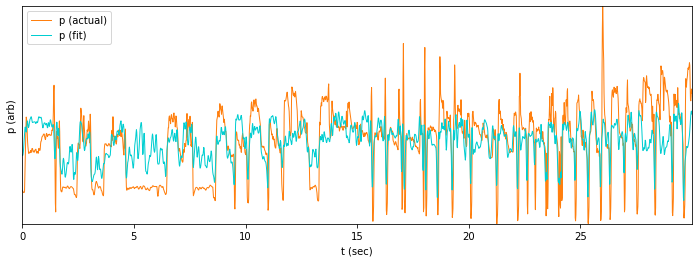

In [98]:
y = all_col_pd['pre_filt'].values
x = all_col_pd[['spk_gpf_0', 'spk_gpf_1', 'spk_gpf_2']].values
x_l = all_col_pd[['spk_gpf_0', 'spk_gpf_1']].values

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

lr = linear_model.Lasso(alpha=0.1)
lr.fit(x_l[:10000], y[:10000].reshape(-1, 1))

y_t = y[10000:]
y_p_l = lr.predict(x_l[10000:])

p_real = y_t[:2000]
p_fit = y_p_l[:2000]
t = np.arange(p_fit.size)*0.015

fit_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4));



ax.plot(t, p_real, 'tab:orange', lw=1, label='p (actual)')
ax.plot(t, p_fit, 'darkturquoise', lw=1, label='p (fit)')

ax.set_ylabel('p (arb)')
ax.set_xlabel('t (sec)')

ax.set_yticks([])
ax.legend()

score = r2_score(y_t, y_p_l)
score

In [99]:
##save the figure
fig_path = os.path.join(exp_struct['folders']['processed'], 'pre_fit_fig')
fit_fig.savefig(fig_path + '.png')
fit_fig.savefig(fig_path + '.eps')
logger.info('saved figure in ' + fig_path)

2023-02-24 14:54:49,012 matplotlib.backends.backend_ps WARNING  The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2023-02-24 14:54:49,024 root         INFO     saved figure in /mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-07-16/sglx/1426_g0/pre_fit_fig


### try a  delay embedding

In [101]:
gpf_arr = bout_df.iloc[20]['spk_gpf']
gpf_arr.shape

(8, 3226)

In [102]:
pre_arr = bout_df.iloc[20]['pre_resample']
pre_arr.shape

(3226,)

In [103]:
from gtda.time_series import Resampler, SlidingWindow, takens_embedding_optimal_parameters, \
    TakensEmbedding, PermutationEntropy, SingleTakensEmbedding
# gtda plotting functions
from gtda.plotting import plot_heatmap
# Plotting functions
from gtda.plotting import plot_point_cloud

In [104]:
max_time_delay = 10
max_embedding_dimension = 10
stride = 1
gp_factor = 0

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    gpf_arr[gp_factor], max_time_delay, max_embedding_dimension, stride=stride
    )

print(optimal_time_delay)

10


In [105]:
optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    pre_arr, max_time_delay, max_embedding_dimension, stride=stride
    )

print(optimal_time_delay)

10


Text(0.5, 0.92, 'GPF_0, tau=3, n=3')

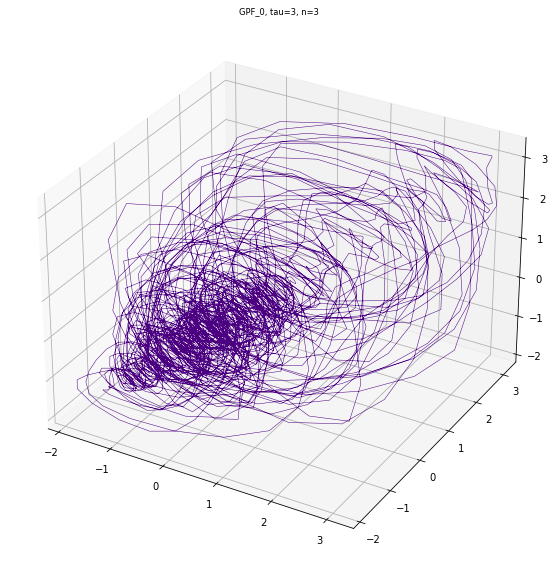

In [106]:
time_delay = 3
dimension = 3
gp_factor = 0

t_e = SingleTakensEmbedding(time_delay=time_delay, dimension=dimension)

gpf_embed = t_e.fit_transform(gpf_arr[gp_factor])
pre_embed = t_e.fit_transform(pre_arr)

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot3D(*(gpf_embed.T[:3]), 'indigo', lw=0.5)
ax.set_title('GPF_{}, tau={}, n={}'.format(gp_factor, time_delay, dimension))

Text(0.5, 0.92, 'pressure; tau=3, n=3')

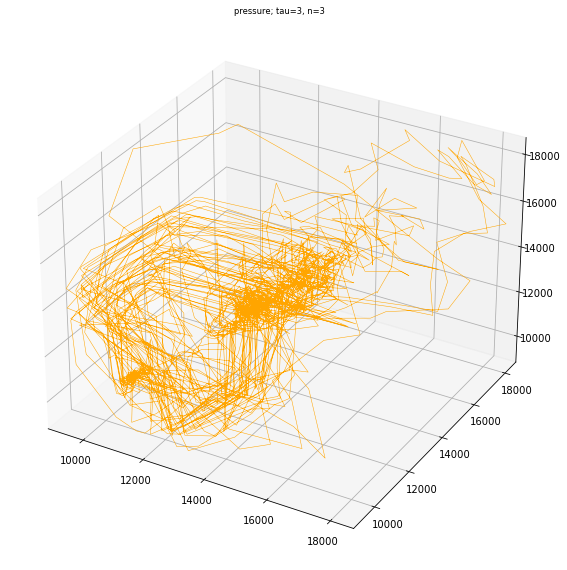

In [107]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot3D(*(pre_embed.T[:3]), 'orange', lw=0.5)
ax.set_title('pressure; tau={}, n={}'.format(time_delay, dimension))

## A better way to do the regressions maybe?

## separate trial/test by entire bout. Train on some bouts, test on others

In [108]:
bout_df.head(1)

,index,f_xx,mic_arr,pre_arr,pre_filt,s_xx,spk_arr,spk_gpf,sxx_pc,syl_in,...,gpf_pre_fit_err,gpf_res_fit,spk_gpf_0,spk_gpf_1,sxx_pc_0,spk_gpf_3,sxx_pc_1,spk_gpf_2,spk_gpf_5,sxx_pc_2
0,0,"[156.25, 234.375, 312.5, 390.625, 468.75, 546....","[-16, -37, -11, -26, -17, -6, -15, -18, -23, -...","[10617, 10619, 10618, 10622, 10638, 10629, 106...","[10618.533427714361, 10620.036464742285, 10621...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.4789022968430218, 0.5379992067507383, 0.51...","[[-4.7570343, 1.5821906, 0.5377069], [-4.75703...","[[8712163, 8712223], [8712278, 8712363], [8712...",...,"[0.22141445152125874, 0.23198410572715086, 0.2...","[0.08203539538081929, 0.08423027571959768, 0.0...","[0.4789022968430218, 0.5379992067507383, 0.515...","[-0.38019432447104645, -0.3087635538504136, -0...","[-4.7570343, -4.7570343, -4.7570343, -4.757034...","[0.23279985019953997, 0.20701660005460473, 0.1...","[1.5821906, 1.5821906, 1.5821906, 1.5821906, 1...","[0.19918795080817475, 0.14583402833102962, 0.0...","[-0.21681492630081478, -0.3028583804169391, -0...","[0.5377069, 0.5377069, 0.5377069, 0.5377069, 0..."


In [109]:
idx_arr = np.array(bout_df.index)
np.random.shuffle(idx_arr)

test_fraction = 0.25
n_test = int(idx_arr.size * test_fraction)

train_idx = idx_arr[-n_test:]
test_idx = idx_arr[:-n_test]

In [110]:
def pre_gpf_match(bs: pd.Series):
    pre = bs['pre_filt']
    gpf = bs['spk_gpf']
    
    n_gpf = gpf.shape[-1]
    n_pre = pre.shape[0]
    
    bin_ratio = int(np.floor(n_pre/n_gpf))
    
    n_common = int(min(np.ceil(n_pre/bin_ratio), n_pre))-1
    
    pre = pre[::bin_ratio][:n_common]
    gpf = gpf[: n_common]
    
    return pre, gpf
    
#df_fit = bout_df.apply(pre_gpf_match, axis=1)

bout_df[['pre_to_fit', 'gpf_to_fit']] = bout_df.apply(pre_gpf_match, axis=1, result_type='expand')

In [111]:
bout_df.iloc[0]['gpf_to_fit'].shape

(8, 4868)

In [112]:
bout_df.iloc[0]['pre_to_fit'].shape

(4868,)

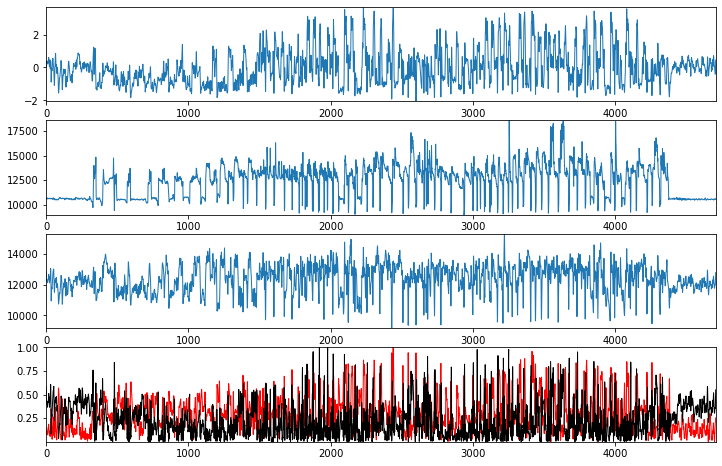

In [113]:
# try one fit-plot
i_bout = 1

x = bout_df.iloc[i_bout]['gpf_to_fit'].T
y = bout_df.iloc[i_bout]['pre_to_fit'].reshape([-1, 1])

gpf_spread = bout_df.iloc[i_bout]['gpf_spread']

lr = linear_model.LinearRegression()
lr.fit(x, y)


y_p = lr.predict(x)
y_err = np.abs(y-y_p)/np.abs(y)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12, 8));


ax[0].plot(x[:,0], lw=1);
ax[1].plot(y, lw=1);
ax[2].plot(y_p, lw=1);
ax[3].plot(gpf_spread/np.max(gpf_spread), 'r', lw=1)
ax[3].plot(y_err/np.max(y_err), 'k', lw=1)

In [115]:
# x is the gpfa
# y is the pressure, say
x = np.hstack(bout_df.iloc[test_idx]['gpf_to_fit'].values).T
y = np.hstack(bout_df.iloc[test_idx]['pre_to_fit']).reshape([-1, 1])

# do the training
lr = linear_model.Lasso(alpha=0.1)
lr.fit(x[:,:], y)


# fit all the bouts
bout_df['pre_gpf'] = bout_df['gpf_to_fit'].apply(lambda p: lr.predict(x[:,:]))

In [116]:
bout_idx = test_idx[0]
bout_df.iloc[bout_idx]['pre_gpf']

array([11299.45236304, 11274.64732748, 11278.40520159, ...,
       12328.18315539, 12394.93435198, 12442.59525883])

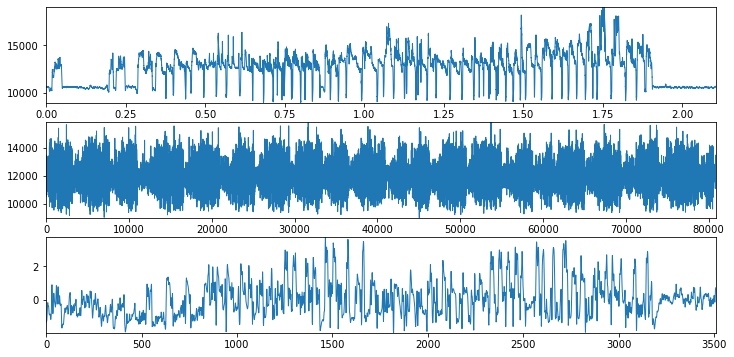

In [117]:
bout_idx = test_idx[0]
bout_s = bout_df.iloc[bout_idx]

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 6));


ax[0].plot(bout_s['pre_filt'], lw=1);
ax[1].plot(bout_s['pre_gpf'], lw=1);
ax[2].plot(bout_s['gpf_to_fit'][0], lw=1);

In [118]:
#plt.plot(x[:2000])


pre_p = lr.predict(x[10000:, :1])

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 6));
ax[0].plot(y[:2000], lw=1)
ax[1].plot(x[:2000], lw=1)
ax[2].plot(pre_p[:2000], lw=1)

ValueError: X has 1 features, but Lasso is expecting 8 features as input.

In [281]:
bout_df['pre_gpf'].iloc[0].shape

(92568,)

In [282]:
bout_df['pre_filt'].iloc[0].shape

(2648400,)

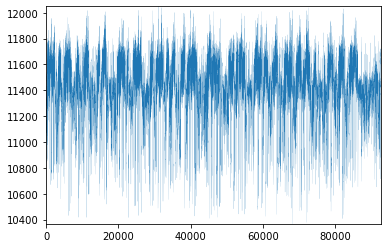

In [284]:
plt.plot(bout_df.loc[10, 'pre_gpf'])

In [234]:
bin_ratio

600

In [119]:
plt.plot(bout_df.loc[1, 'pre_filt'][::bin_ratio])

NameError: name 'bin_ratio' is not defined

In [198]:
x.shape

(92568, 6)

In [199]:
y.shape

(1, 92568)

In [187]:
x.shape

(92568, 6)

In [184]:
bout_df.loc[0, 'pre_filt']

array([10783.85059687, 10782.99704464, 10782.14820697, ...,
       11154.40733152, 11154.64971932, 11154.86158814])

In [176]:
x.shape

(130397, 3)

In [177]:
y.shape

(130397,)

0.20745728888918624

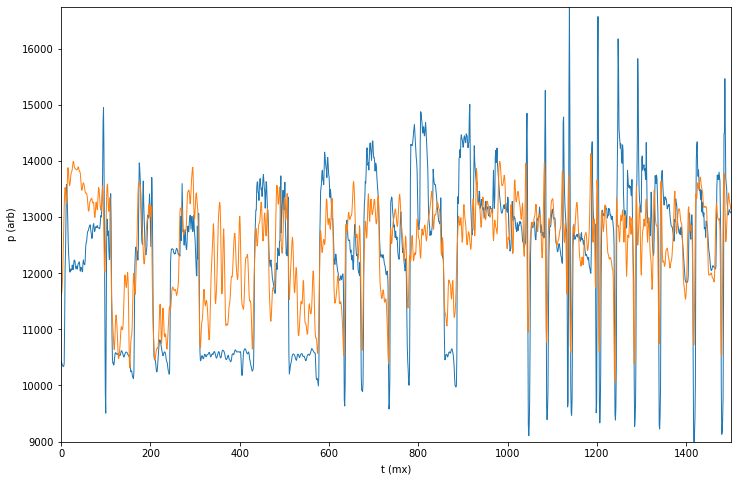

In [120]:
y = all_col_pd['pre_filt'].values
x = all_col_pd[['spk_gpf_0', 'spk_gpf_1', 'spk_gpf_2']].values
x_l = all_col_pd[['spk_gpf_0', 'spk_gpf_1']].values

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

lr = linear_model.Lasso(alpha=0.1)
lr.fit(x[:10000], y[:10000].reshape(-1, 1))

pre_t = y[10000:]
pre_p = lr.predict(x[10000:])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8));

plot_len = 1500
t = np.arange(plot_len)*15

ax.plot(pre_t[:plot_len], lw=1)
ax.plot(pre_p[:plot_len], lw=1)

ax.set_ylabel('p (arb)')
ax.set_xlabel('t (mx)')

score = r2_score(pre_t, pre_p)
score

In [192]:
x[:10000].shape

(10000, 3)

In [191]:
y[:10000].reshape(-1, 1).shape

(10000, 1)

ValueError: Found input variables with inconsistent numbers of samples: [93395, 4707]

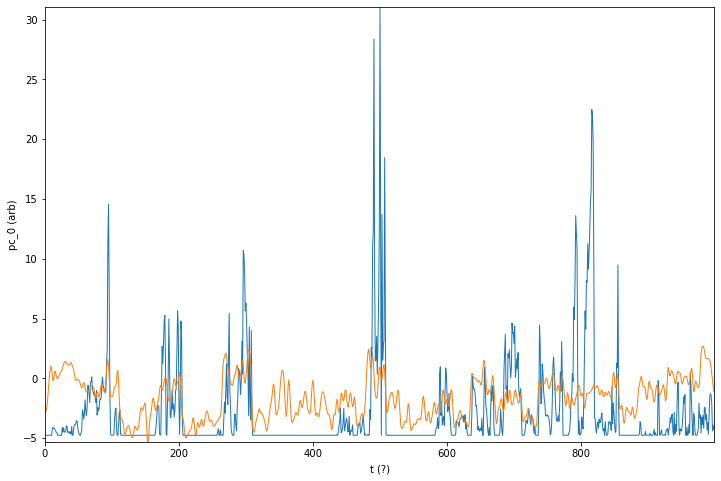

In [121]:
y = all_col_pd['sxx_pc_0'].values
x = all_col_pd[['spk_gpf_0', 'spk_gpf_1', 'spk_gpf_2']].values

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

lr = linear_model.LinearRegression()
lr.fit(x[:10000], y[:10000].reshape(-1, 1))

pc_t = y[10000:]
pc_p = lr.predict(x[10000:])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8));


ax.plot(pc_t[:1000], lw=1)
ax.plot(pc_p[:1000], lw=1)

ax.set_ylabel('pc_0 (arb)')
ax.set_xlabel('t (?)')

score = r2_score(y_t, y_p)
score

ValueError: Found input variables with inconsistent numbers of samples: [93395, 4707]

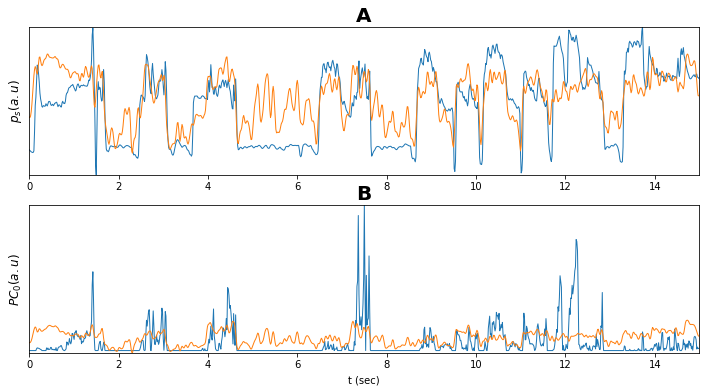

In [122]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6));

plot_len = 1000
t = np.arange(plot_len)*15*0.001

ax[0].plot(t, pre_t[:plot_len], lw=1)
ax[0].plot(t, pre_p[:plot_len], lw=1)
ax[0].set_title('A', fontsize=20, fontweight='bold')
ax[0].set_ylabel(r'$p_{s} (a.u)$', fontsize=12)
ax[0].set_yticks([])

ax[1].plot(t, pc_t[:plot_len], lw=1)
ax[1].plot(t, pc_p[:plot_len], lw=1)
ax[1].set_title('B', fontsize=20, fontweight='bold')

ax[1].set_ylabel(r'$PC_{0} (a.u)$', fontsize=12)
ax[1].set_xlabel('t (sec)')
ax[1].set_yticks([])

score = r2_score(y_t, y_p)
score

In [123]:
mutual_info = lambda x, y: mutual_info_regression(x.reshape(-1, 1), y)

def bout_correlations(bout_s, tag_pair= ['spk_gpf_0', 'sxx_pc_0'], corr_function=mutual_info,
                     shuffle_control=False):
    
    ## t has to be in last axis
    tag_tuple = tuple(tag_pair)
    
    # subsample everything to the series with the least temporal resolution (gp, 15ms bins)
    n_samp_arr = np.array([bout_s[x].shape[-1] for x in tag_pair])
    #logger.info(n_samp_arr)
    # sort by number of samples (0 is smaller, 1 is larger)
    size_order = np.argsort(n_samp_arr)
    short_tag, long_tag = np.array(tag_pair)[size_order]
    
    # leav the smaller untouched (the 0), subsample the larger (1)
    sizes_ranked = np.sort(n_samp_arr)
    size_ratio = sizes_ranked[1]//sizes_ranked[0]
    
    long_s = pu.coarse(bout_s[long_tag], size_ratio)[:sizes_ranked[0]]
    short_s = bout_s[short_tag]
    
    if shuffle_control:
        short_x = np.random.permutation(short_s)
    
    else:
        short_x = short_s
    
    #print(short_x.shape)
    corr_val = corr_function(long_s, short_x)[0]
    return corr_val

bout_correlations(bout_df.iloc[3], corr_function=mutual_info, shuffle_control=False)

0.15458570194575394

In [108]:
bout_df.keys()

Index(['f_xx', 'mic_arr', 'pre_arr', 'pre_filt', 's_xx', 'spk_arr', 'spk_gpf',
       'sxx_pc', 'syl_in', 't_xx', 'bout_check', 'confusing', 'end_ms',
       'end_sample', 'end_sample_ap_0', 'file', 'len_ms', 'len_sample_ap_0',
       'start_ms', 'start_ms_ap_0', 'start_sample', 'start_sample_ap_0',
       'start_sample_naive', 'bout_idx', 'spk_bin_arr', 'spk_ms_arr',
       's_xx_env', 'env_bin', 'env_log', 'pre_ms', 'pre_bin', 'spk_pc',
       'pre_fr_fit', 'spk_train_t40', 'spk_gpf_t40', 'spk_train_b40',
       'spk_gpf_b40', 'gpf_spread', 'pre_resample', 'gpf_pre_fit',
       'gpf_pre_fit_err', 'gpf_res_fit', 'gpf_pre_fit_t40', 'gpf_pre_fit_b40',
       'spk_gpf_0', 'spk_gpf_1', 'sxx_pc_0', 'spk_gpf_3', 'sxx_pc_1',
       'spk_gpf_2', 'spk_gpf_5', 'sxx_pc_2', 'spk_gpf_t40_0', 'spk_gpf_t40_1',
       'spk_gpf_t40_3', 'spk_gpf_t40_2', 'spk_gpf_t40_5', 'spk_gpf_b40_0',
       'spk_gpf_b40_1', 'spk_gpf_b40_3', 'spk_gpf_b40_2', 'spk_gpf_b40_5'],
      dtype='object')

In [135]:
corr_pairs = [['sxx_pc_0', 'pre_filt'], ['spk_gpf_0', 'pre_filt'], ['spk_gpf_0', 'sxx_pc_0']]
corr_pairs = [['spk_gpf_0', 'sxx_pc_0'], ['spk_gpf_0', 'pre_filt'],
              ['spk_gpf_1', 'sxx_pc_0'], ['spk_gpf_1', 'pre_filt'],
             ['spk_gpf_0', 'spk_gpf_1']]

corr_pairs = [['spk_gpf_0', 'sxx_pc_0'], ['spk_gpf_0', 'pre_filt']]
corr_dict = {}

for corr_pair in corr_pairs:
    k = corr_pair[0] + '-' + corr_pair[1]
    
    corr_dict[k] =  bout_df.apply(lambda x: bout_correlations(x, corr_pair, 
                                                              corr_function=mutual_info), 
                                  axis=1)
    
    corr_dict[k+'_shuffle'] = bout_df.apply(lambda x: bout_correlations(x, corr_pair, 
                                                              corr_function=mutual_info, 
                                                                       shuffle_control=True), 
                                  axis=1)
    
corr_df = pd.DataFrame.from_dict(corr_dict)

(-0.1, 1.0)

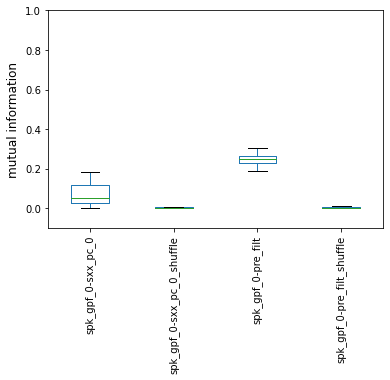

In [125]:
fig, ax = plt.subplots()
corr_df.boxplot(ax=ax, grid=False, rot=45, showfliers=False)
ax.set_xticklabels(corr_df.keys(), rotation=90)
ax.set_ylabel('mutual information', fontsize=12)

# for grant figure we want just pca and 
ax.set_ylim([-0.1, 1])
# ax.set_xticklabels([r"$\left<GPFA, PCA\right>$", 
#                     r"$\left<GPFA, PCA\right>_{shuff}$", 
#                     r"$\left<GPFA, p_{s}\right>$", 
#                     r"$\left<GPFA, p_{s}\right>_{shuff}$", ], fontsize=12, rotation=30)

In [126]:
fig_path = os.path.join(exp_struct['folders']['processed'], 'fig_mutual_info.eps')
fig.savefig(fig_path, bbox_inches='tight')
logger.info('saved figure to ' + fig_path)

2023-02-24 14:57:37,123 root         INFO     saved figure to /mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-07-16/sglx/1426_g0/fig_mutual_info.eps


In [136]:
pairs = [['spk_gpf_0-sxx_pc_0', 'spk_gpf_0-sxx_pc_0_shuffle']]
pairs.append(['spk_gpf_0-pre_filt', 'spk_gpf_0-pre_filt_shuffle'])
pairs.append(['spk_gpf_0-pre_filt', 'spk_gpf_0-sxx_pc_0'])

for p in pairs:
    p.append(stats.mannwhitneyu(corr_df[p[0]], corr_df[p[1]]).pvalue)
    
pairs

[['spk_gpf_0-sxx_pc_0', 'spk_gpf_0-sxx_pc_0_shuffle', 1.381971572491812e-10],
 ['spk_gpf_0-pre_filt', 'spk_gpf_0-pre_filt_shuffle', 2.1141724302377144e-11],
 ['spk_gpf_0-pre_filt', 'spk_gpf_0-sxx_pc_0', 8.993406027014868e-11]]

In [137]:
corr_dict = {}

for corr_pair in corr_pairs:
    k = corr_pair[0] + '-' + corr_pair[1]
    
    corr_dict[k] =  bout_df.apply(lambda x: bout_correlations(x, corr_pair, 
                                                              corr_function=pearsonr), 
                                  axis=1)
    
corr_df = pd.DataFrame.from_dict(corr_dict)

(-1.0, 1.0)

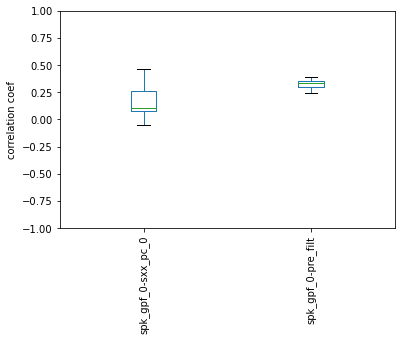

In [138]:
fig, ax = plt.subplots()
corr_df.boxplot(ax=ax, grid=False, rot=45, showfliers=False)
ax.set_xticklabels(corr_df.keys(), rotation=90)
ax.set_ylabel('correlation coef')

# for grant figure we want just pca and 
ax.set_ylim([-1, 1])
#ax.set_xticklabels(['<pca, gpa>', '<p_sub, gpfa>'], rotation=60)

In [130]:
corr_df.keys()

Index(['spk_gpf_0-sxx_pc_0', 'spk_gpf_0-pre_filt'], dtype='object')

In [131]:
corr_df

,spk_gpf_0-sxx_pc_0,spk_gpf_0-pre_filt
0,0.272791,0.284651
1,0.083835,0.342613
12,0.365980,0.372275
23,0.342076,0.392176
24,0.116664,0.375274
25,0.319813,0.356580
26,0.098999,0.345911
27,0.106597,0.333080
28,0.075862,0.340596
29,0.062481,0.335032


In [132]:
from scipy import stats

In [139]:
pairs = [['spk_gpf_0-sxx_pc_0', 'spk_gpf_0-sxx_pc_0_shuffle']]
pairs.append(['spk_gpf_0-pre_filt', 'spk_gpf_0-pre_filt_shuffle'])
pairs.append(['spk_gpf_0-pre_filt', 'spk_gpf_0-sxx_pc_0'])

for p in pairs:
    p.append(stats.mannwhitneyu(corr_df[p[0]], corr_df[p[1]]).pvalue)

KeyError: 'spk_gpf_0-sxx_pc_0_shuffle'

In [144]:
pairs

[['spk_gpf_0-sxx_pc_0', 'spk_gpf_0-sxx_pc_0_shuffle', 5.137021413328932e-30],
 ['spk_gpf_0-pre_filt', 'spk_gpf_0-pre_filt_shuffle', 1.7022095974602283e-31],
 ['spk_gpf_0-pre_filt', 'spk_gpf_0-sxx_pc_0', 1.642470958469077e-21]]

In [136]:
corr_df[pairs[0][0]]

0     0.370228
1     0.053414
2     0.040523
3     0.344092
4     0.033794
        ...   
85    0.513786
86    0.328392
87    0.256135
88    0.350610
89    0.311817
Name: spk_gpf_0-sxx_pc_0, Length: 90, dtype: float64

In [141]:
stats.mannwhitneyu(corr_df[p[0]], corr_df[p[1]]).pvalue

1.7022095974602283e-31